# BigTable MTLM - dataset perplexity testing

Aim of this notebook:
1. Generate student + question datasets
2. Generate N sets of encounters
3. Report on agreement between these sets

The error between the datasets (for large N) is the inherent probabilistic error in the model
- How does this translate to tolerances in the $\alpha$ and $\delta$ parameters

## Model perplexity
A model $q$ is used to predict the values of a set of samples, $\mathbf{x}$.  Perplexity is defined as:

\\[{perplex}_{q}(\mathbf{x}) = b^{-\frac{1}{N}\Sigma_{i=1}^{N}{log_{b}(q(x_i))}}\\]

Perplexity is a measure of `surprise' as a divergence from the predictions that are seen in the true values.


In [263]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 10
min_active_traits = 10
max_active_traits = 10


In [264]:
generate_student_name()

'NOFI PHEM '

In [265]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.9999
q_p_hardest = 0.0001
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/min_active_traits)
pr_k_hardest = q_p_hardest**(1/max_active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

# null_task_pr = 1/(1+exp(-baseline))
# print("null-task passrate", null_task_pr)
# print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**max_active_traits)
print("best Pr=", best_comp_pr**min_active_traits)

theta_mid = (theta_max+theta_min)/2
beta_mid = (beta_max+beta_min)/2

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 6.963114313065643
th 6.549756149564769 12.512870462630412
worst cmp chance= 0.3981071705534971
best cmp chance= 0.9999899995499715
worst Pr= 9.99999999999996e-05
best Pr= 0.9998999999999998
limits 0.9961266558149183 0.9961266558149183
[[1 2 3]
 [7 8 9]]
(2, 3)


In [278]:
sigmoid = lambda z: 1/(1+exp(-z))

class Question():
    def __init__(self, qix, min_diff, max_diff, nt, n_active):
        self.id = qix

        if n_active:
            if len(n_active)==2:
                min_active = n_active[0]
                max_active = n_active[1]
                n_c =  numpy.random.choice(range(min_active, max_active+1))
        else:
            n_c = nt

        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        
  
        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = inv_sigmoid(p) 
#             self.betas[c]=0
            self.betas[c]= uniform(1,11)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        
        self.thetas = [ not_present for _ in range(nt) ]        

                
        minp=sigmoid(min_a)
        maxp=sigmoid(max_a)
                
        for c in choices:
#             self.betas[c] = min_diff
#             assume_b = 6#uniform(1,11)
#             assume_pass = uniform(.0001**(1/n_c), .9999**(1/n_c))
# #             p = random.uniform(.0001**(1/n_c), .9999**(1/n_c))
# #             p = random.uniform(minp, maxp)
# #             self.thetas[c] = inv_sigmoid(p) + 6
# #             self.thetas[c] = 0
#             z = inv_sigmoid(assume_pass)
#             th = z + assume_b
#             self.thetas[c]= th
            self.thetas[c] = uniform(7,22)

In [267]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [268]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
#         if b==0:
#             p_pass_step=1.0
#         else:
#             if th==0:
# #                 print("blocking component, ret 0")
#                 return 0
#             else:
        z = (th-b)
        p_pass_step = 1.0 / (1.0 + exp(-z))
# #                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [269]:
def create_qs_from_blobs(n_qs, n_clusters, nt=n_traits):
    from sklearn.datasets.samples_generator import make_blobs
    from sklearn.preprocessing import MinMaxScaler
    
    #beta_min,beta_max
    sc = MinMaxScaler(feature_range=(beta_min, beta_max))
    
    X, y = make_blobs(n_samples=n_qs, centers=n_clusters, n_features=nt, cluster_std=2, random_state=666)
#     baseline = numpy.min(X)
#     X = X - baseline
    X = sc.fit_transform(X)

    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()
    
    qns = []
    for qix, (blob, y) in enumerate(zip(X,y)):
        qn = Question(qix, 0,0, nt=nt, nnw=nnw)
        qn.betas = blob
        qn.group = y
        qns.append(qn)
        
    mags = []
    no_comps = []
    for q in qns:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
        
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    qn_table = BigTable((n_qs, nt),min_w=0, max_w=beta_max)    
    return qns, qn_table

In [270]:
def create_qs(n_qs, nt, active_limits):

    max_mag = sqrt((beta_max**2)*nt)
    min_mag = sqrt((beta_min**2)*nt)
    print("Vector length limits:",min_mag,max_mag)
    
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt, active_limits) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    return master_qs

In [271]:
def create_students(n_students, nt=n_traits):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)
    
    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [272]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    passes=0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
#                     pp,passed = attempt_q(psi, q)
#                     tup = (psi.id, q.id, passed, passed)
#                     attempt_n_map[(q.id,psi.id)] += 1
#                     attempts.append(tup)
#                     print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
#                     attempts_by_psi[psi.name].append(tup)
#                     attempts_by_q[q].append(tup)
#                     att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
#                     qs.remove(qix)
                pp,passed = attempt_q(psi, q)
                if passed:
                    passes+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print("passed {}/{}".format(passes,len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

Vector length limits: 3.1622776601683795 22.019300837406174
Q:0, difficulty=22.37 across 10 components
Q:1, difficulty=24.75 across 10 components
Q:2, difficulty=21.43 across 10 components
Q:3, difficulty=17.13 across 10 components
Q:4, difficulty=26.13 across 10 components
Q:5, difficulty=24.57 across 10 components
Q:6, difficulty=19.89 across 10 components
Q:7, difficulty=22.62 across 10 components
Q:8, difficulty=23.14 across 10 components
Q:9, difficulty=12.28 across 10 components
Q:10, difficulty=24.21 across 10 components
Q:11, difficulty=25.66 across 10 components
Q:12, difficulty=18.05 across 10 components
Q:13, difficulty=20.29 across 10 components
Q:14, difficulty=19.84 across 10 components
Q:15, difficulty=19.49 across 10 components
Q:16, difficulty=20.87 across 10 components
Q:17, difficulty=14.35 across 10 components
Q:18, difficulty=24.55 across 10 components
Q:19, difficulty=23.76 across 10 components
Q:20, difficulty=24.90 across 10 components
Q:21, difficulty=22.09 acr

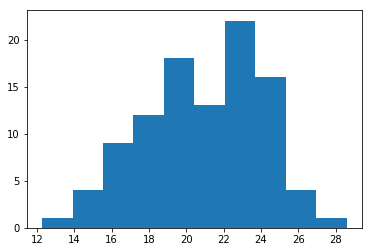

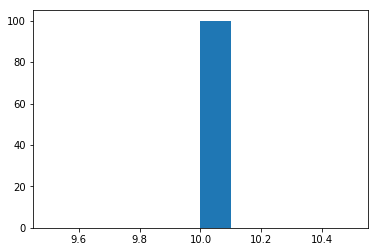

qid 0 [5.343754968307887, 2.231420937871801, 4.854936732156333, 9.113594841043065, 6.536737425539719, 5.561196489769683, 9.147597621524993, 10.033231539802642, 8.121747682476842, 6.006266907917189]
qid 1 [10.216589677068022, 7.1051264065525555, 10.674559330059665, 7.291099598044565, 9.918256877276406, 1.9938025699844577, 2.697708984559437, 1.1676515575428217, 7.8155299240808, 10.888178277721876]
qid 2 [7.202400777061282, 5.200656441521393, 8.025141513721199, 2.3023292004749365, 10.01225641530077, 6.285116881872119, 1.8635898563679112, 6.170472025197412, 4.11152728003357, 10.601172504490265]
qid 3 [1.3441654460113441, 1.4587237068665662, 5.609721563015193, 8.371460715187359, 3.1751487581061935, 3.5603511054462524, 9.368827025697017, 8.601444362602656, 1.5084127810496453, 1.1395448431560442]
qid 4 [8.945202662212779, 10.300712009961766, 8.513019674633558, 9.175253548778938, 10.188617946181761, 6.009797532371373, 10.275269639394603, 5.262098548259915, 6.318966526851847, 5.192959248106237]

FEB SIMOF , skill=51.10 across 10 comps
CUKER PEPHU , skill=47.76 across 10 comps
GOTO JYC , skill=43.42 across 10 comps
PHEMO LUTHOTH , skill=52.67 across 10 comps
MIF WIL , skill=44.29 across 10 comps
TAR NAPY , skill=45.37 across 10 comps
LAMAG DATHIV , skill=47.20 across 10 comps
JUCHEG HIPHEN , skill=42.12 across 10 comps
JUTHAG HIMAM , skill=48.25 across 10 comps
THUY DIR , skill=45.91 across 10 comps
BIW GAJ , skill=52.49 across 10 comps


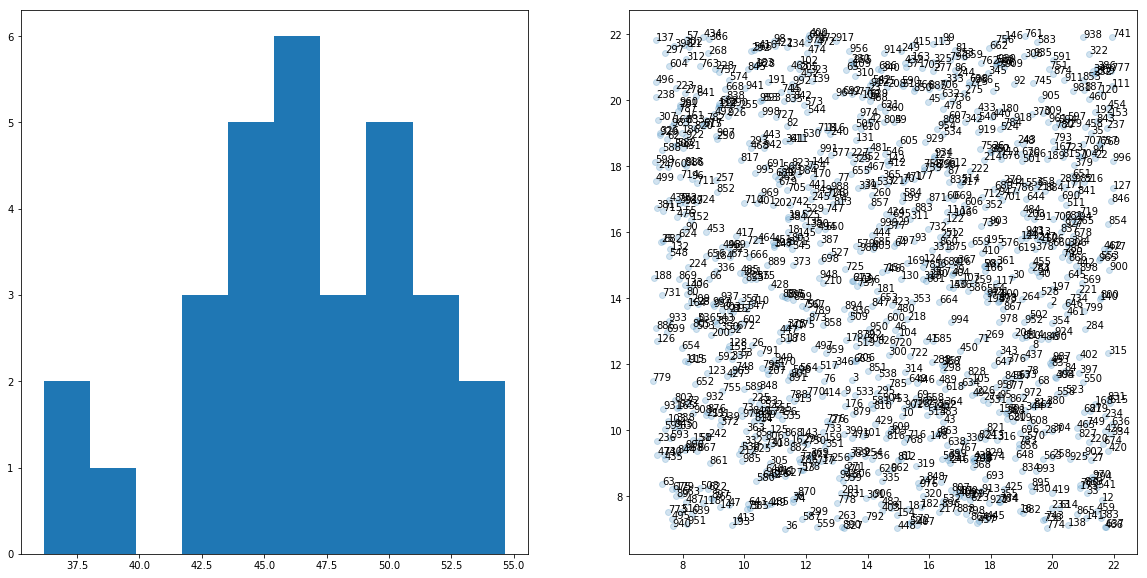

----0

passed 50108/100000
----0

passed 50300/100000
----0

passed 50059/100000
----0

passed 50055/100000
----0

passed 50124/100000
----0

passed 50275/100000
----0

passed 50270/100000
----0

passed 50199/100000
----0

passed 50343/100000
----0

passed 50000/100000
model acc: 0.749213
376119 125173
373094 125614
perplexity is 1.4802878615490904


In [279]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 100
n_students = 1000
opt = Adam(lr=0.5)# (lr=.75)

n_epochs = 10

qs = create_qs(n_qs, n_traits, (min_active_traits, max_active_traits))
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
ss = create_students(n_students, n_traits)

x = []

for _ in range(n_epochs):
    xa, _,_,_ = generate_attempts(qs,ss) # this is our x list of samples
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)
    
    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1
        
acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(tn,fn)
        
ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))

In [ ]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [ ]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()